##### This Notebook has been adapted from a course gave by Robert Gower at AMMI

# First order methods on regression models

    Lab 1 : Optimization for Machine Learning, AMMI Master's in Machine Intelligence

## Aim

The aim of this material is to code 
- proximal gradient descent (ISTA)
- accelerated gradient descent (FISTA) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- ridge penalization
- L1 penalization

## VERY IMPORTANT


- **Each** student must send their jupyter notebook solutions **before the 5th of July at 23:59**  to **tngoupeyou@aimsammi.org**
- The **name of the file must be** constructed as in the next cell

### How to construct the name of your file

In [59]:
# Change here using YOUR first and last names
fn1 = "Arnaud"
ln1 = "Watusadisi_Mavakala"
filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab1", ln1, fn1])) + ".ipynb"
print(filename)

lab1_watusadisi_mavakala_arnaud.ipynb


In [60]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

Text(0.5, 1.0, 'Parameters / Coefficients')

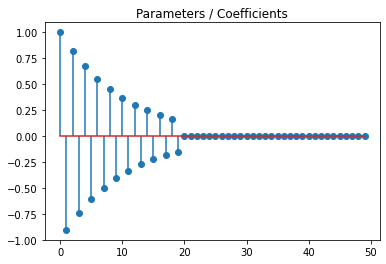

In [62]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [63]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))

def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b = 2 * b - 1
    return A, b

## Part 1 : Proximal operators

We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + g(z) \right\}.
$$


We have in mind to use the following cases

- Ridge penalization, where $g(z) = \frac{s}{2} \|z\|_2^2$
- Lasso penalization, where $g(z) = s \|z|\|_1$

where $s \geq 0$ is a regularization parameter.

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Code a function that computes $g(x)$ in both cases and $\text{prox}_g(x)$ for ridge and  lasso penalization (use the slides of the first course to get the formulas), using the prototypes given below</li>
      <li>Visualize the functions applied element wise by the proximity operators of the Ridge and Lasso 
    </li>
    </ul>
</div>

#ANSWERS

In [64]:
def prox_lasso(x, s,t=1):
    """Proximal operator for the Lasso at x"""    
    return np.sign(x)*np.maximum(np.abs(x)-s*t,0) # TODO
    
def lasso(x, s):
    """Value of the Lasso penalization at x"""
    return s*np.linalg.norm((x), ord=1) # TODO

def prox_ridge(x, s, t=1.):
    """Proximal operator for the ridge at x"""    
    return x/(1.+s*t) # TODO
    
def ridge(x, s):
    """Value of the ridge penalization at x"""
    return (s/2.) * (np.linalg.norm((x), ord=2) ** 2)
 # TODO

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

(-2.0, 2.0)

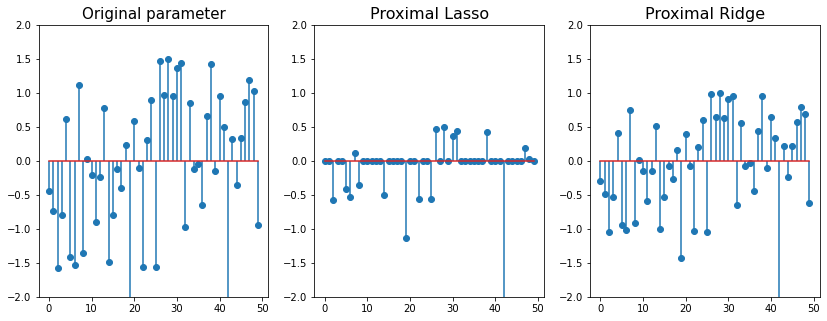

In [65]:
x = randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(14.0, 5.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=15)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_lasso(x, s=l_l1))
plt.title("Proximal Lasso", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_ridge(x, s=l_l2))
plt.title("Proximal Ridge", fontsize=16)
plt.ylim([-2, 2])

<div class="alert alert-success">
    <b>Question</b>:
     <ul>
      <li>Comment what you observe (1 or 2 sentences).</li>
    </ul>
</div>

# Comment
We notice that in the lasso regularization, the absolute valued coefficients under $t\cdot s$ disappear because the proximal operator is such that $ \text{sign}(x)(|x|-t \cdot s)_{+} $ and the non-zero coefficients decrease by the scalar $t\cdot s$. Hence, the L1 norm induces sparsity. But during a ridge regularization, the value of the coefficients is smaller but still positive. The amplitude of the coefficients is decreased by the same factor $\frac{1}{1 + t\cdot s}$.

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + g(x)
$$
where $f$ is $L$-smooth and $g$ is prox-capable.

Consider the following cases:

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A$ is the matrix of features.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)</li>
      <li>Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.</li>
      <li>Check that these functions are correct by numerically checking the gradient, using the function ``<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html">check_grad</a>`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model</li>
    </ul>
</div>

#Answers

In [66]:
def loss_linreg(x):
    return 0.5 * norm(b - A.dot(x)) ** 2 / n_samples

def grad_linreg(x):
    """Leas-squares gradient"""
    # TODO
    result=-1/(len(b)) * np.dot(A.T, b - np.dot(A,x))
    return result

def loss_logreg(x):
    u = b * A.dot(x)
    return np.sum(np.log(1 + np.exp(-u))) / n_samples

def grad_logreg(x):
    """Logistic gradient"""
    # TODO
    result=sum((-b[i]*np.transpose(A[i, :]) * np.exp(-b[i]*np.dot(np.transpose(A[i, :]), x))) / (len(b) * (1 + np.exp(-b[i]*np.dot(np.transpose(A[i, :]), x)))) for i in range(len(b)))

    return result

# TO BE COMPLETED

#check gradient

In [67]:
from scipy.optimize import check_grad
A,b = simu_linreg(coefs)
print("Check grad_linreg:", check_grad(loss_linreg, grad_linreg, x0=randn(A.shape[1])))
A,b = simu_logreg(coefs)
print("Check grad_logreg:", check_grad(loss_logreg, grad_logreg, x0=randn(A.shape[1])))

Check grad_linreg: 1.8141381321378762e-06
Check grad_logreg: 1.0993096936552516e-07


## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $g$ and $\text{prox}_g$. 

We want now to code the Ista and Fista solvers to minimize

$$
\arg\min_x f(x) + g(x)
$$

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm</a> (read the documentation
  of the function)</li>
      <li>Finish the functions `ista` below that implements the 
  ISTA (Proximal Gradient Descent) algorithm</li>
    <li> BONUS QUESTION:  Implement FISTA (Accelerated Proximal 
  Gradient Descent) algorithm as described at the bottom
    </ul>
</div>

#Answers

In [68]:
# TO BE COMPLETED

def lip_linreg(A):
    """Lipschitz constant for linear squares loss"""    
    # TODO
    result=1/(len(b)) * np.linalg.norm(np.dot(A.T,A), ord=2)
    return result
def lip_logreg(A):
    """Lipschitz constant for logistic loss"""    
    
    # TODO
    result=1/(4. * len(b)) * np.linalg.norm(A, ord=2)**2
    return result 
    
def ista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
          x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    if verbose:
        print("Lauching ISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO ####
        x = prox_g(x - step*grad_f(x), s, step)

        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

Try and implement the FISTA algorithm (detailed in maths below)

FISTA Algorithm:
$$\begin{array}{l}
\mbox{Set } w^1=0=z^1, \beta^1 =1\\
\mbox{for }t=1,2,3, \ldots, T \quad  \\
\qquad \displaystyle w^{t+1} = \mbox{prox}_{\left. \lambda R \right/ \mathcal{L}}\left( z^t - \frac{1}{\mathcal{L}} \nabla L(z^t)\right) \\
\qquad \displaystyle \beta^{t+1} = \frac{1+\sqrt{1+4(\beta^t)^2}}{2}\\
\qquad \displaystyle  z^{t+1} = w^{t+1} + \frac{\beta^t -1}{\beta^{t+1}} (w^{t+1} -w^{t})\\
\mbox{Output } w^{T+1}
\end{array}$$

In [69]:
# TO BE COMPLETED

def fista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for FISTA
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching FISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO ####
        x_new = prox_g(z - step*grad_f(z),s, step)
        t_new = (1/2)*(1 + np.sqrt(1 + 4*(t**2)))
        z_new = x_new + ((t-1)/t_new)*(x_new - x)
        x, z, t = x_new, z_new, t_new
        
        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [70]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 40
s = 1e-2
s

0.01

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute a precise minimum and a precise minimizer of the linear regression with ridge 
  penalization problem using the parameters give above. This can be done by using fista with 
  1000 iterations.</li>
    <li>Compare the convergences of ISTA and FISTA, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.</li>
    </ul>
</div>

### Let's compute an accurate minimum and an accurate minimizer of the linear regression problem with peak penalty using the parameters given above. This can be done using FISTA with 1000 iterations.

In [71]:
# Minimum and minimizer of the linear regression with ridge penalization
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
step=1/lip_linreg(A)
X, obj, err = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s, n_iter=1000,x_true=coefs, verbose=True)
minimum = obj[-1]
minimizer = X[-1]
print("minimum:", minimum)
print("minimizer:", minimizer)

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 1.17e+00 | 8.87e-01
      10 | 4.84e-01 | 1.27e-01
      20 | 4.83e-01 | 1.36e-01
      30 | 4.83e-01 | 1.32e-01
      40 | 4.83e-01 | 1.33e-01
      50 | 4.83e-01 | 1.33e-01
      60 | 4.83e-01 | 1.33e-01
      70 | 4.83e-01 | 1.33e-01
      80 | 4.83e-01 | 1.33e-01
      90 | 4.83e-01 | 1.33e-01
     100 | 4.83e-01 | 1.33e-01
     110 | 4.83e-01 | 1.33e-01
     120 | 4.83e-01 | 1.33e-01
     130 | 4.83e-01 | 1.33e-01
     140 | 4.83e-01 | 1.33e-01
     150 | 4.83e-01 | 1.33e-01
     160 | 4.83e-01 | 1.33e-01
     170 | 4.83e-01 | 1.33e-01
     180 | 4.83e-01 | 1.33e-01
     190 | 4.83e-01 | 1.33e-01
     200 | 4.83e-01 | 1.33e-01
     210 | 4.83e-01 | 1.33e-01
     220 | 4.83e-01 | 1.33e-01
     230 | 4.83e-01 | 1.33e-01
     240 | 4.83e-01 | 1.33e-01
     250 | 4.83e-01 | 1.33e-01
     260 | 4.83e-01 | 1.33e-01
     270 | 4.83e-01 | 1.33e-01
     280 | 4.83e-01 | 1.33e-01
     290 | 4.83e-01 | 1.33e-01
     300 | 4.8

#Let us Compare the convergences of ISTA and FISTA, in terms of distance to the minimum and distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.

#1) Study of the convergence for the ridge penalization.


-Convergence of the term (it can be viewed as a distance to the minimizer)


In [72]:
# Ridge penalization : 
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
step=1/lip_linreg(A)
Xi_lin, obji_lin, erri_lin = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s, n_iter=1000,x_true=coefs, verbose=True)
Xf_lin, objf_lin, errf_lin = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s, n_iter=1000,x_true=coefs, verbose=True)

A, b = simu_logreg(coefs, n_samples=1000, corr=0.5)
step=1/lip_logreg(A)
Xi_log, obji_log, erri_log = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s, n_iter=1000,x_true=coefs, verbose=True)
Xf_log, objf_log, errf_log = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s, n_iter=1000,x_true=coefs, verbose=True)


Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 1.23e+00 | 8.87e-01
      10 | 5.77e-01 | 3.23e-01
      20 | 5.11e-01 | 1.61e-01
      30 | 5.03e-01 | 1.26e-01
      40 | 5.02e-01 | 1.22e-01
      50 | 5.02e-01 | 1.21e-01
      60 | 5.02e-01 | 1.21e-01
      70 | 5.02e-01 | 1.21e-01
      80 | 5.02e-01 | 1.21e-01
      90 | 5.02e-01 | 1.21e-01
     100 | 5.02e-01 | 1.21e-01
     110 | 5.02e-01 | 1.21e-01
     120 | 5.02e-01 | 1.21e-01
     130 | 5.02e-01 | 1.21e-01
     140 | 5.02e-01 | 1.21e-01
     150 | 5.02e-01 | 1.21e-01
     160 | 5.02e-01 | 1.21e-01
     170 | 5.02e-01 | 1.21e-01
     180 | 5.02e-01 | 1.21e-01
     190 | 5.02e-01 | 1.21e-01
     200 | 5.02e-01 | 1.21e-01
     210 | 5.02e-01 | 1.21e-01
     220 | 5.02e-01 | 1.21e-01
     230 | 5.02e-01 | 1.21e-01
     240 | 5.02e-01 | 1.21e-01
     250 | 5.02e-01 | 1.21e-01
     260 | 5.02e-01 | 1.21e-01
     270 | 5.02e-01 | 1.21e-01
     280 | 5.02e-01 | 1.21e-01
     290 | 5.02e-01 | 1.21e-01
     300 | 5.02

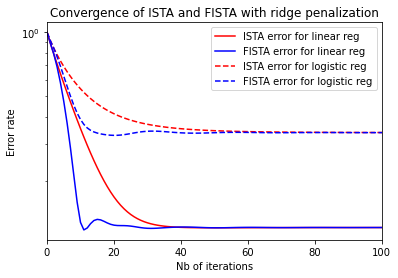

In [73]:
plt.plot(erri_lin,'r',label = "ISTA error for linear reg")
plt.plot(errf_lin,'b',label = "FISTA error for linear reg")
plt.plot(erri_log,'r--',label = "ISTA error for logistic reg")
plt.plot(errf_log,'b--',label = "FISTA error for logistic reg")
plt.yscale('log')
plt.xlabel("Nb of iterations")
plt.ylabel("Error rate")
plt.legend()
plt.title("Convergence of ISTA and FISTA with ridge penalization")
plt.xlim(0,100)
plt.show()

- 

-Convergence in terms of distance to the minimum. Let us do the plot here also

<ipython-input-74-c102a234c633>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


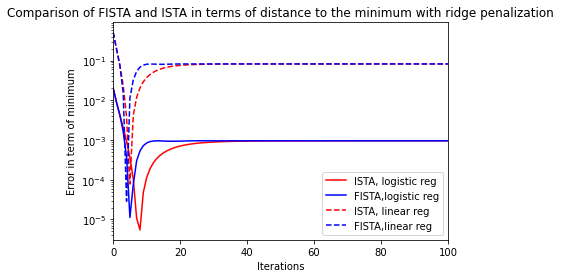

In [74]:
true_obj_lin = loss_linreg(coefs) + ridge(coefs, s)
true_obj_log = loss_logreg(coefs) + ridge(coefs, s)
plt.plot((obji_log- true_obj_log)**2,'r',label = "ISTA, logistic reg")
plt.plot((objf_log- true_obj_log)**2,'b',label = "FISTA,logistic reg")
plt.plot((obji_lin- true_obj_lin)**2,'r--',label = "ISTA, linear reg")
plt.plot((objf_lin- true_obj_lin)**2,'b--',label = "FISTA,linear reg")
ax = plt.subplot(111)
ax.set_yscale('log')
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Error in term of minimum")
plt.title("Comparison of FISTA and ISTA in terms of distance to the minimum with ridge penalization")
plt.xlim(0,100)
plt.show()

#Study of the convergence with lasso penalization.

In [75]:
 #Lasso penalization : 
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
step=1/lip_linreg(A)
Xi_lin, obji_lin, erri_lin = ista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step, s, n_iter=1000,x_true=coefs, verbose=True)
Xf_lin, objf_lin, errf_lin = fista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step, s, n_iter=1000,x_true=coefs, verbose=True)

A, b = simu_logreg(coefs, n_samples=1000, corr=0.5)
step=1/lip_logreg(A)
Xi_log, obji_log, erri_log = ista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step, s, n_iter=1000,x_true=coefs, verbose=True)
Xf_log, objf_log, errf_log = fista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step, s, n_iter=1000,x_true=coefs, verbose=True)


Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 1.29e+00 | 8.89e-01
      10 | 6.13e-01 | 3.32e-01
      20 | 5.48e-01 | 1.72e-01
      30 | 5.41e-01 | 1.29e-01
      40 | 5.40e-01 | 1.18e-01
      50 | 5.40e-01 | 1.14e-01
      60 | 5.40e-01 | 1.13e-01
      70 | 5.40e-01 | 1.12e-01
      80 | 5.40e-01 | 1.12e-01
      90 | 5.40e-01 | 1.12e-01
     100 | 5.40e-01 | 1.12e-01
     110 | 5.40e-01 | 1.12e-01
     120 | 5.40e-01 | 1.12e-01
     130 | 5.40e-01 | 1.12e-01
     140 | 5.40e-01 | 1.12e-01
     150 | 5.40e-01 | 1.12e-01
     160 | 5.40e-01 | 1.12e-01
     170 | 5.40e-01 | 1.12e-01
     180 | 5.40e-01 | 1.12e-01
     190 | 5.40e-01 | 1.12e-01
     200 | 5.40e-01 | 1.12e-01
     210 | 5.40e-01 | 1.12e-01
     220 | 5.40e-01 | 1.12e-01
     230 | 5.40e-01 | 1.12e-01
     240 | 5.40e-01 | 1.12e-01
     250 | 5.40e-01 | 1.12e-01
     260 | 5.40e-01 | 1.12e-01
     270 | 5.40e-01 | 1.12e-01
     280 | 5.40e-01 | 1.12e-01
     290 | 5.40e-01 | 1.12e-01
     300 | 5.40

#-Convergence in terms of distance to the minimizer  - lasso penalization.


Let us do the plot

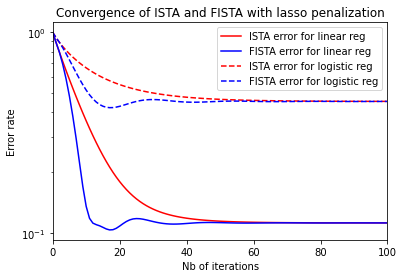

In [76]:
#linear regression
plt.plot(erri_lin,'r',label = "ISTA error for linear reg")
plt.plot(errf_lin,'b',label = "FISTA error for linear reg")
plt.plot(erri_log,'r--',label = "ISTA error for logistic reg")
plt.plot(errf_log,'b--',label = "FISTA error for logistic reg")
plt.yscale('log')
plt.xlabel("Nb of iterations")
plt.ylabel("Error rate")
plt.legend()
plt.title("Convergence of ISTA and FISTA with lasso penalization")
plt.xlim(0,100)
plt.show()

## Convergence in terms of distance to the minimum  - lasso penalization
Let us do the plot here

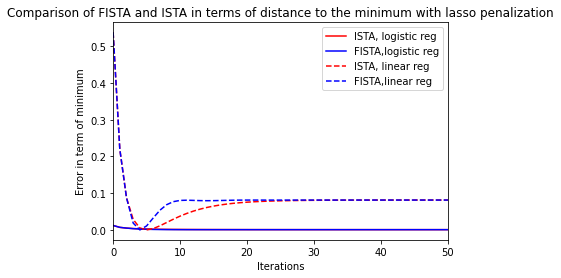

In [77]:

true_obj_lin = loss_linreg(coefs) + ridge(coefs, s)
true_obj_log = loss_logreg(coefs) + ridge(coefs, s)

ax.set_yscale('log')
plt.plot((obji_log- true_obj_log)**2,'r',label = "ISTA, logistic reg")
plt.plot((objf_log- true_obj_log)**2,'b',label = "FISTA,logistic reg")
plt.plot((obji_lin- true_obj_lin)**2,'r--',label = "ISTA, linear reg")
plt.plot((objf_lin- true_obj_lin)**2,'b--',label = "FISTA,linear reg")

ax.set_yscale('log')
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Error in term of minimum")
plt.title("Comparison of FISTA and ISTA in terms of distance to the minimum with lasso penalization")
plt.xlim(0,50)
plt.show()


## Comments 
We notice that the FISTA algorithm (blue) converges faster than the ISTA algorithm (red). But also, for both algorithms and penalties, we see that the error is larger when a logistic regression is used.

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with ista and fista with the true parameter `coefs` of
  the model. This can be done with `plt.stem` plots.</li>
    <li>In linear regression and logistic regression, study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, study the influence of the level of ridge 
  penalization on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, compare the performance of the optimization
  algorithms for ridge and lasso penalizations. Explain</li>
    </ul>
</div>

### Answers
#### - We will use both data sets for simulations of the influence of feature correlation.

#FISTA algorithm

-This part concerns the linear regression with ridge and lasso penalization.

In [78]:
Constante_lin = []

A, b = simu_linreg(coefs, n_samples=200, corr=0.2)
step= 1/lip_linreg(A)
Constante_lin.append(lip_linreg(A))
low_rf = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=s, n_iter =200)
low_lf = fista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step, s=s, n_iter =200)

A, b = simu_linreg(coefs, n_samples=200, corr=0.5)
step= 1/lip_linreg(A)
Constante_lin.append(lip_linreg(A))
med_rf = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=s, n_iter =200)
med_lf = fista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step, s=s, n_iter =200)

A, b = simu_linreg(coefs, n_samples=200, corr=0.8)
step= 1/lip_linreg(A)
Constante_lin.append(lip_linreg(A))
high_rf = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=s, n_iter =200)
high_lf = fista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step, s=s, n_iter =200) 

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 2.13e-01 | 7.52e-01
      10 | 8.98e-02 | 2.20e-01
      20 | 8.88e-02 | 2.31e-01
      30 | 8.90e-02 | 2.28e-01
      40 | 8.89e-02 | 2.29e-01
      50 | 8.90e-02 | 2.28e-01
      60 | 8.89e-02 | 2.28e-01
      70 | 8.89e-02 | 2.29e-01
      80 | 8.89e-02 | 2.28e-01
      90 | 8.89e-02 | 2.28e-01
     100 | 8.89e-02 | 2.28e-01
     110 | 8.89e-02 | 2.28e-01
     120 | 8.89e-02 | 2.28e-01
     130 | 8.89e-02 | 2.28e-01
     140 | 8.89e-02 | 2.28e-01
     150 | 8.89e-02 | 2.28e-01
     160 | 8.89e-02 | 2.28e-01
     170 | 8.89e-02 | 2.28e-01
     180 | 8.89e-02 | 2.28e-01
     190 | 8.89e-02 | 2.28e-01
     200 | 8.89e-02 | 2.28e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 2.52e-01 | 7.54e-01
      10 | 1.61e-01 | 2.07e-01
      20 | 1.59e-01 | 2.22e-01
      30 | 1.59e-01 | 2.18e-01
      40 | 1.59e-01 | 2.19e-01
      50 | 1.59e-01 | 2.19e-01
      60 | 1.59e-01 | 2.19e-01
      70 | 1.59e-01 

- Here we have the logistic regression with ridge and lasso penalization.

In [79]:

Constante_log = []

A, b = simu_logreg(coefs, n_samples=200, corr=0.2)
step= 1/lip_logreg(A)
Constante_log.append(lip_logreg(A))
low_log_rf = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=s, n_iter =200)
low_log_lf = fista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step, s=s, n_iter =200)

A, b = simu_logreg(coefs, n_samples=200, corr=0.5)
step= 1/lip_logreg(A)
Constante_log.append(lip_logreg(A))
med_log_rf = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=s, n_iter =200)
med_log_lf = fista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step, s=s, n_iter =200)

A, b = simu_logreg(coefs, n_samples=200, corr=0.8)
step= 1/lip_logreg(A)
Constante_log.append(lip_logreg(A))
high_log_rf = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=s, n_iter =200)
high_log_lf = fista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step, s=s, n_iter =200)

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 1.16e-01 | 8.65e-01
      10 | 1.08e-01 | 7.85e-01
      20 | 1.11e-01 | 8.20e-01
      30 | 1.09e-01 | 7.96e-01
      40 | 1.10e-01 | 8.06e-01
      50 | 1.10e-01 | 8.03e-01
      60 | 1.10e-01 | 8.03e-01
      70 | 1.10e-01 | 8.04e-01
      80 | 1.10e-01 | 8.03e-01
      90 | 1.10e-01 | 8.03e-01
     100 | 1.10e-01 | 8.03e-01
     110 | 1.10e-01 | 8.03e-01
     120 | 1.10e-01 | 8.03e-01
     130 | 1.10e-01 | 8.03e-01
     140 | 1.10e-01 | 8.03e-01
     150 | 1.10e-01 | 8.03e-01
     160 | 1.10e-01 | 8.03e-01
     170 | 1.10e-01 | 8.03e-01
     180 | 1.10e-01 | 8.03e-01
     190 | 1.10e-01 | 8.03e-01
     200 | 1.10e-01 | 8.03e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 1.37e-01 | 8.82e-01
      10 | 1.72e-01 | 7.18e-01
      20 | 1.73e-01 | 7.18e-01
      30 | 1.72e-01 | 7.15e-01
      40 | 1.73e-01 | 7.17e-01
      50 | 1.72e-01 | 7.16e-01
      60 | 1.72e-01 | 7.16e-01
      70 | 1.72e-01 

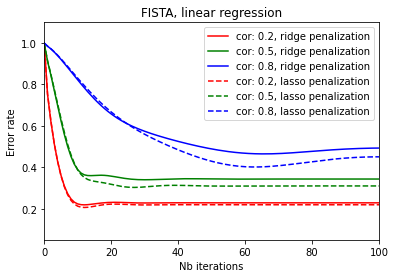

lipschitz constant: [2.4781645551844242, 4.025825426280216, 8.885514189222002]
lipschitz constant:  [0.6294966790302812, 0.9665707818260855, 2.5425497511579906]


In [80]:
# Linear regression, both penalizations
fig = plt.figure()
plt.plot(low_rf[2], 'r', label = 'cor: 0.2, ridge penalization')
plt.plot(med_rf[2], 'g', label = 'cor: 0.5, ridge penalization')
plt.plot(high_rf[2], 'b', label = 'cor: 0.8, ridge penalization')
plt.plot(low_lf[2], 'r--', label = 'cor: 0.2, lasso penalization')
plt.plot(med_lf[2], 'g--', label = 'cor: 0.5, lasso penalization')
plt.plot(high_lf[2], 'b--', label = 'cor: 0.8, lasso penalization')
plt.xlabel('Nb iterations')
plt.ylabel('Error rate')
plt.xlim(0, 100)
plt.ylim(0.05, 1.1)
plt.title('FISTA, linear regression')
plt.legend()
plt.show()
print("lipschitz constant:", Constante_lin)
print("lipschitz constant: ", Constante_log)

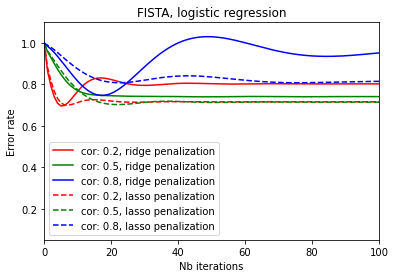

lipschitz constant: [2.4781645551844242, 4.025825426280216, 8.885514189222002]
lipschitz constant:  [0.6294966790302812, 0.9665707818260855, 2.5425497511579906]


In [81]:
 #Logistic regression
fig = plt.figure()
plt.plot(low_log_rf[2], 'r', label = 'cor: 0.2, ridge penalization')
plt.plot(med_log_rf[2], 'g', label = 'cor: 0.5, ridge penalization')
plt.plot(high_log_rf[2], 'b', label = 'cor: 0.8, ridge penalization')
plt.plot(low_log_lf[2], 'r--', label = 'cor: 0.2, lasso penalization')
plt.plot(med_log_lf[2], 'g--', label = 'cor: 0.5, lasso penalization')
plt.plot(high_log_lf[2], 'b--', label = 'cor: 0.8, lasso penalization')
plt.xlabel('Nb iterations')
plt.ylabel('Error rate')
plt.xlim(0, 100)
plt.ylim(0.05, 1.1)
plt.title('FISTA, logistic regression')
plt.legend()
plt.show()
print("lipschitz constant:", Constante_lin)
print("lipschitz constant: ", Constante_log)

#ISTA algorithm

- Here we have linear regression with ridge and lasso penalization.

In [82]:
Constante_lin = []

A, b = simu_linreg(coefs, n_samples=200, corr=0.2)
step= 1/lip_linreg(A)
Constante_lin.append(lip_linreg(A))
low_r = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=s, n_iter =200)
low_l = ista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step, s=s, n_iter =200)

A, b = simu_linreg(coefs, n_samples=200, corr=0.5)
step= 1/lip_linreg(A)
Constante_lin.append(lip_linreg(A))
med_r = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=s, n_iter =200)
med_l = ista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step, s=s, n_iter =200)

A, b = simu_linreg(coefs, n_samples=200, corr=0.8)
step= 1/lip_linreg(A)
Constante_lin.append(lip_linreg(A))
high_r = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=s, n_iter =200)
high_l = ista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step, s=s, n_iter =200)

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 2.54e-01 | 7.20e-01
      10 | 1.01e-01 | 2.61e-01
      20 | 1.01e-01 | 2.70e-01
      30 | 1.02e-01 | 2.75e-01
      40 | 1.02e-01 | 2.77e-01
      50 | 1.02e-01 | 2.77e-01
      60 | 1.02e-01 | 2.78e-01
      70 | 1.02e-01 | 2.78e-01
      80 | 1.02e-01 | 2.78e-01
      90 | 1.02e-01 | 2.78e-01
     100 | 1.02e-01 | 2.78e-01
     110 | 1.02e-01 | 2.78e-01
     120 | 1.02e-01 | 2.78e-01
     130 | 1.02e-01 | 2.78e-01
     140 | 1.02e-01 | 2.78e-01
     150 | 1.02e-01 | 2.78e-01
     160 | 1.02e-01 | 2.78e-01
     170 | 1.02e-01 | 2.78e-01
     180 | 1.02e-01 | 2.78e-01
     190 | 1.02e-01 | 2.78e-01
     200 | 1.02e-01 | 2.78e-01
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 2.95e-01 | 7.24e-01
      10 | 1.76e-01 | 2.50e-01
      20 | 1.81e-01 | 2.44e-01
      30 | 1.82e-01 | 2.46e-01
      40 | 1.83e-01 | 2.46e-01
      50 | 1.83e-01 | 2.46e-01
      60 | 1.83e-01 | 2.46e-01
      70 | 1.83e-01 | 

- Here we have logistic regression with ridge and lasso penalization.

In [83]:
Constante_log = []

A, b = simu_logreg(coefs, n_samples=200, corr=0.2)
step= 1/lip_logreg(A)
Constante_log.append(lip_logreg(A))
low_log_r = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=s, n_iter =200)
low_log_l = ista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step, s=s, n_iter =200)

A, b = simu_logreg(coefs, n_samples=200, corr=0.5)
step= 1/lip_logreg(A)
Constante_log.append(lip_logreg(A))
med_log_r = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=s, n_iter =200)
med_log_l = ista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step, s=s, n_iter =200)

A, b = simu_logreg(coefs, n_samples=200, corr=0.8)
step= 1/lip_logreg(A)
Constante_log.append(lip_logreg(A))
high_log_r = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=s, n_iter =200)
high_log_l = ista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step, s=s, n_iter =200)


Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 1.13e-01 | 8.39e-01
      10 | 1.00e-01 | 5.24e-01
      20 | 1.04e-01 | 5.32e-01
      30 | 1.07e-01 | 5.54e-01
      40 | 1.08e-01 | 5.69e-01
      50 | 1.09e-01 | 5.77e-01
      60 | 1.09e-01 | 5.81e-01
      70 | 1.09e-01 | 5.84e-01
      80 | 1.10e-01 | 5.85e-01
      90 | 1.10e-01 | 5.86e-01
     100 | 1.10e-01 | 5.86e-01
     110 | 1.10e-01 | 5.86e-01
     120 | 1.10e-01 | 5.86e-01
     130 | 1.10e-01 | 5.86e-01
     140 | 1.10e-01 | 5.86e-01
     150 | 1.10e-01 | 5.86e-01
     160 | 1.10e-01 | 5.86e-01
     170 | 1.10e-01 | 5.86e-01
     180 | 1.10e-01 | 5.86e-01
     190 | 1.10e-01 | 5.86e-01
     200 | 1.10e-01 | 5.86e-01
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 1.37e-01 | 8.59e-01
      10 | 1.56e-01 | 5.37e-01
      20 | 1.63e-01 | 4.94e-01
      30 | 1.66e-01 | 4.86e-01
      40 | 1.67e-01 | 4.84e-01
      50 | 1.68e-01 | 4.83e-01
      60 | 1.68e-01 | 4.83e-01
      70 | 1.68e-01 | 

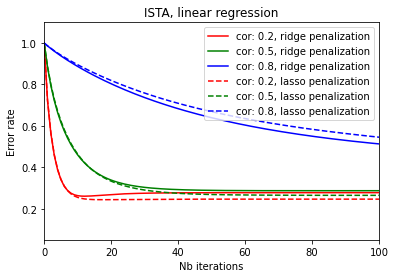

lipschitz constant: [2.4425090310796476, 3.710959700153225, 9.374061532206477]
lipschitz constant:  [0.5916487579317888, 0.940297914140499, 2.0292494112996757]


In [84]:
# Linear regression

fig = plt.figure()
plt.plot(low_r[2], 'r', label = 'cor: 0.2, ridge penalization')
plt.plot(med_r[2], 'g', label = 'cor: 0.5, ridge penalization')
plt.plot(high_r[2], 'b', label = 'cor: 0.8, ridge penalization')
plt.plot(low_l[2], 'r--', label = 'cor: 0.2, lasso penalization')
plt.plot(med_l[2], 'g--', label = 'cor: 0.5, lasso penalization')
plt.plot(high_l[2], 'b--', label = 'cor: 0.8, lasso penalization')
plt.xlabel('Nb iterations')
plt.ylabel('Error rate')
plt.xlim(0, 100)
plt.ylim(0.05, 1.1)
plt.title('ISTA, linear regression')
plt.legend()
plt.show()
print("lipschitz constant:", Constante_lin)
print("lipschitz constant: ", Constante_log)

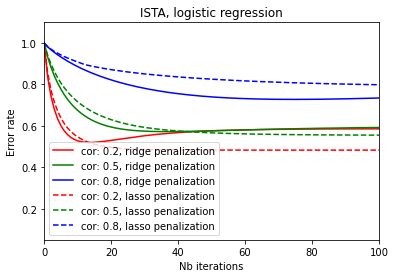

lipschitz constant: [2.4425090310796476, 3.710959700153225, 9.374061532206477]
lipschitz constant:  [0.5916487579317888, 0.940297914140499, 2.0292494112996757]


In [85]:
 #Logistic regression

fig = plt.figure()
plt.plot(low_log_r[2], 'r', label = 'cor: 0.2, ridge penalization')
plt.plot(med_log_r[2], 'g', label = 'cor: 0.5, ridge penalization')
plt.plot(high_log_r[2], 'b', label = 'cor: 0.8, ridge penalization')
plt.plot(low_log_l[2], 'r--', label = 'cor: 0.2, lasso penalization')
plt.plot(med_log_l[2], 'g--', label = 'cor: 0.5, lasso penalization')
plt.plot(high_log_l[2], 'b--', label = 'cor: 0.8, lasso penalization')
plt.xlabel('Nb iterations')
plt.ylabel('Error rate')
plt.xlim(0, 100)
plt.ylim(0.05, 1.1)
plt.title('ISTA, logistic regression')
plt.legend()
plt.show()
print("lipschitz constant:", Constante_lin)
print("lipschitz constant: ", Constante_log)

#FISTA vs ISTA



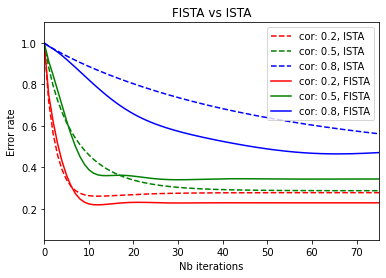

In [86]:
fig = plt.figure()
plt.plot(low_r[2], 'r--', label = 'cor: 0.2, ISTA')
plt.plot(med_r[2], 'g--', label = 'cor: 0.5, ISTA')
plt.plot(high_r[2], 'b--', label = 'cor: 0.8, ISTA')
plt.plot(low_rf[2], 'r', label = 'cor: 0.2, FISTA')
plt.plot(med_rf[2], 'g', label = 'cor: 0.5, FISTA')
plt.plot(high_rf[2], 'b', label = 'cor: 0.8, FISTA')

plt.xlabel('Nb iterations')
plt.ylabel('Error rate')
plt.xlim(0, 75)
plt.ylim(0.05, 1.1)
plt.title('FISTA vs ISTA')
plt.legend()
plt.show()

### We notice that the FISTA algorithm (blue) converges faster than the ISTA algorithm (red). But also, for both algorithms and penalties, we see that the error is lower when a linear regression is used.

# - Influence of the level of ridge penalization

#FISTA ALGORITHM

In [87]:
# linear regression
A, b = simu_linreg(coefs, n_samples=200, corr=0.5)
step= 1/lip_linreg(A)
lin1f = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=0, n_iter =200)
lin2f = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=0.02, n_iter =200)
lin3f = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=0.1, n_iter =200)
lin4f = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=0.25, n_iter =200)
lin5f = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=0.8, n_iter =200)
lin6f = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=1, n_iter =200)
lin7f = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=5, n_iter =200)

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 1.99e-01 | 9.19e-01
      10 | 7.33e-02 | 4.30e-01
      20 | 7.03e-02 | 4.59e-01
      30 | 7.00e-02 | 4.47e-01
      40 | 7.00e-02 | 4.40e-01
      50 | 7.00e-02 | 4.45e-01
      60 | 7.00e-02 | 4.44e-01
      70 | 7.00e-02 | 4.43e-01
      80 | 7.00e-02 | 4.44e-01
      90 | 7.00e-02 | 4.44e-01
     100 | 7.00e-02 | 4.44e-01
     110 | 7.00e-02 | 4.44e-01
     120 | 7.00e-02 | 4.44e-01
     130 | 7.00e-02 | 4.44e-01
     140 | 7.00e-02 | 4.44e-01
     150 | 7.00e-02 | 4.44e-01
     160 | 7.00e-02 | 4.44e-01
     170 | 7.00e-02 | 4.44e-01
     180 | 7.00e-02 | 4.44e-01
     190 | 7.00e-02 | 4.44e-01
     200 | 7.00e-02 | 4.44e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 2.00e-01 | 9.19e-01
      10 | 1.12e-01 | 4.37e-01
      20 | 1.19e-01 | 4.38e-01
      30 | 1.15e-01 | 4.33e-01
      40 | 1.16e-01 | 4.30e-01
      50 | 1.16e-01 | 4.33e-01
      60 | 1.16e-01 | 4.32e-01
      70 | 1.16e-01 

In [88]:
# logistic regression
A, b = simu_logreg(coefs, n_samples=200, corr=0.5)
step= 1/lip_logreg(A)
log1f = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=0, n_iter =200)
log2f = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=0.02, n_iter =200)
log3f = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=0.1, n_iter =200)
log4f = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=0.25, n_iter =200)
log5f = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=0.8, n_iter =200)
log6f = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=1, n_iter =200)
log7f = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=5, n_iter =200)

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 1.24e-01 | 9.31e-01
      10 | 8.27e-02 | 6.29e-01
      20 | 7.26e-02 | 1.11e+00
      30 | 7.05e-02 | 1.58e+00
      40 | 7.03e-02 | 1.87e+00
      50 | 7.03e-02 | 1.98e+00
      60 | 7.03e-02 | 1.99e+00
      70 | 7.03e-02 | 1.92e+00
      80 | 7.03e-02 | 1.84e+00
      90 | 7.03e-02 | 1.78e+00
     100 | 7.03e-02 | 1.76e+00
     110 | 7.03e-02 | 1.78e+00
     120 | 7.03e-02 | 1.81e+00
     130 | 7.03e-02 | 1.84e+00
     140 | 7.03e-02 | 1.86e+00
     150 | 7.03e-02 | 1.86e+00
     160 | 7.03e-02 | 1.84e+00
     170 | 7.03e-02 | 1.82e+00
     180 | 7.03e-02 | 1.81e+00
     190 | 7.03e-02 | 1.81e+00
     200 | 7.03e-02 | 1.82e+00
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 1.25e-01 | 9.32e-01
      10 | 1.26e-01 | 5.94e-01
      20 | 1.43e-01 | 6.30e-01
      30 | 1.38e-01 | 6.12e-01
      40 | 1.37e-01 | 6.06e-01
      50 | 1.39e-01 | 6.13e-01
      60 | 1.38e-01 | 6.11e-01
      70 | 1.38e-01 

#Plot 

<ipython-input-89-f56f3a1ad74c>:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


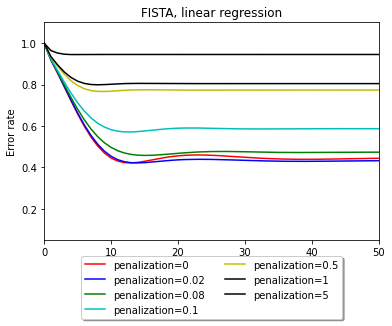

In [89]:
#Linear regression
fig = plt.figure()
plt.plot(lin1f[2], 'r', label = 'penalization=0')
plt.plot(lin2f[2], 'b', label = 'penalization=0.02')
plt.plot(lin3f[2], 'g', label = 'penalization=0.08')
plt.plot(lin4f[2], 'c', label = 'penalization=0.1')
plt.plot(lin5f[2], 'y', label = 'penalization=0.5')
plt.plot(lin6f[2], 'k', label = 'penalization=1')
plt.plot(lin7f[2], 'k', label = 'penalization=5')

plt.xlabel('Nb iterations')
plt.ylabel('Error rate')

plt.xlim(0, 50)
plt.ylim(0.05, 1.1)
plt.title('FISTA, linear regression')
ax = plt.subplot(111)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),  shadow=True, ncol=2)
plt.show()

<ipython-input-90-0a5af1cdfcdc>:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


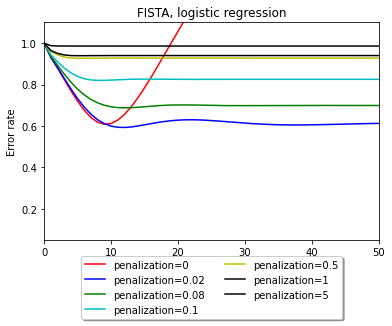

In [90]:
#Logistic regression
fig = plt.figure()
plt.plot(log1f[2], 'r', label = 'penalization=0')
plt.plot(log2f[2], 'b', label = 'penalization=0.02')
plt.plot(log3f[2], 'g', label = 'penalization=0.08')
plt.plot(log4f[2], 'c', label = 'penalization=0.1')
plt.plot(log5f[2], 'y', label = 'penalization=0.5')
plt.plot(log6f[2], 'k', label = 'penalization=1')
plt.plot(log7f[2], 'k', label = 'penalization=5')

plt.xlabel('Nb iterations')
plt.ylabel('Error rate')

plt.xlim(0, 50)
plt.ylim(0.05, 1.1)
plt.title('FISTA, logistic regression')
ax = plt.subplot(111)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),  shadow=True, ncol=2)
plt.show()

#ISTA ALGORITHM

In [91]:
# linear regression
A, b = simu_linreg(coefs, n_samples=200, corr=0.5)
step= 1/lip_linreg(A)
lin1= ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=0, n_iter =200)
lin2 = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=0.02, n_iter =200)
lin3 = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=0.08, n_iter =200)
lin4 = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=0.1, n_iter =200)
lin5 = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=0.5, n_iter =200)
lin6 = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=1, n_iter =200)
lin7 = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=5, n_iter =200)

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 2.26e-01 | 9.23e-01
      10 | 1.10e-01 | 5.27e-01
      20 | 8.90e-02 | 3.74e-01
      30 | 8.27e-02 | 3.10e-01
      40 | 8.05e-02 | 2.84e-01
      50 | 7.96e-02 | 2.74e-01
      60 | 7.93e-02 | 2.71e-01
      70 | 7.91e-02 | 2.69e-01
      80 | 7.91e-02 | 2.69e-01
      90 | 7.91e-02 | 2.69e-01
     100 | 7.90e-02 | 2.69e-01
     110 | 7.90e-02 | 2.69e-01
     120 | 7.90e-02 | 2.69e-01
     130 | 7.90e-02 | 2.69e-01
     140 | 7.90e-02 | 2.69e-01
     150 | 7.90e-02 | 2.69e-01
     160 | 7.90e-02 | 2.69e-01
     170 | 7.90e-02 | 2.69e-01
     180 | 7.90e-02 | 2.69e-01
     190 | 7.90e-02 | 2.69e-01
     200 | 7.90e-02 | 2.69e-01
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 2.27e-01 | 9.23e-01
      10 | 1.31e-01 | 5.37e-01
      20 | 1.24e-01 | 3.89e-01
      30 | 1.25e-01 | 3.25e-01
      40 | 1.28e-01 | 2.95e-01
      50 | 1.29e-01 | 2.80e-01
      60 | 1.30e-01 | 2.72e-01
      70 | 1.31e-01 | 

In [92]:
# logistic regression
A, b = simu_logreg(coefs, n_samples=200, corr=0.5)
step= 1/lip_logreg(A)
log1= ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=0, n_iter =200)
log2 = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=0.02, n_iter =200)
log3 = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=0.08, n_iter =200)
log4 = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=0.1, n_iter =200)
log5 = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=0.5, n_iter =200)
log6 = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=1, n_iter =200)
log7 = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=5, n_iter =200)

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 1.23e-01 | 9.40e-01
      10 | 9.25e-02 | 6.93e-01
      20 | 8.40e-02 | 6.57e-01
      30 | 7.96e-02 | 7.03e-01
      40 | 7.70e-02 | 7.75e-01
      50 | 7.53e-02 | 8.50e-01
      60 | 7.41e-02 | 9.22e-01
      70 | 7.33e-02 | 9.88e-01
      80 | 7.26e-02 | 1.05e+00
      90 | 7.22e-02 | 1.10e+00
     100 | 7.18e-02 | 1.15e+00
     110 | 7.15e-02 | 1.20e+00
     120 | 7.12e-02 | 1.24e+00
     130 | 7.10e-02 | 1.28e+00
     140 | 7.08e-02 | 1.31e+00
     150 | 7.07e-02 | 1.34e+00
     160 | 7.06e-02 | 1.37e+00
     170 | 7.05e-02 | 1.40e+00
     180 | 7.04e-02 | 1.43e+00
     190 | 7.03e-02 | 1.45e+00
     200 | 7.03e-02 | 1.47e+00
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 1.25e-01 | 9.41e-01
      10 | 1.12e-01 | 7.07e-01
      20 | 1.18e-01 | 6.53e-01
      30 | 1.23e-01 | 6.47e-01
      40 | 1.27e-01 | 6.54e-01
      50 | 1.30e-01 | 6.61e-01
      60 | 1.32e-01 | 6.68e-01
      70 | 1.33e-01 | 

#PLOT

<ipython-input-93-ba2f5dc32238>:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


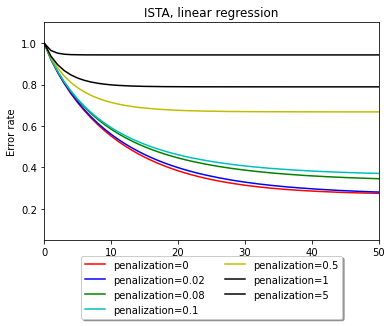

In [93]:
#Linear regression
fig = plt.figure()
plt.plot(lin1[2], 'r', label = 'penalization=0')
plt.plot(lin2[2], 'b', label = 'penalization=0.02')
plt.plot(lin3[2], 'g', label = 'penalization=0.08')
plt.plot(lin4[2], 'c', label = 'penalization=0.1')
plt.plot(lin5[2], 'y', label = 'penalization=0.5')
plt.plot(lin6[2], 'k', label = 'penalization=1')
plt.plot(lin7[2], 'k', label = 'penalization=5')

plt.xlabel('Nb iterations')
plt.ylabel('Error rate')

plt.xlim(0, 50)
plt.ylim(0.05, 1.1)
plt.title('ISTA, linear regression')
ax = plt.subplot(111)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),  shadow=True, ncol=2)
plt.show()

<ipython-input-94-92ec7c8cce00>:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


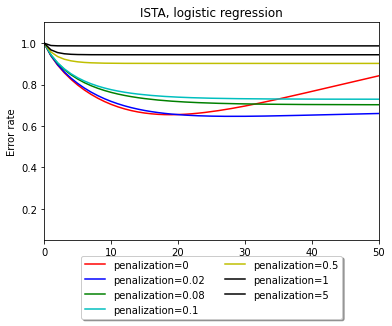

In [94]:
#Logistic regression
fig = plt.figure()
plt.plot(log1[2], 'r', label = 'penalization=0')
plt.plot(log2[2], 'b', label = 'penalization=0.02')
plt.plot(log3[2], 'g', label = 'penalization=0.08')
plt.plot(log4[2], 'c', label = 'penalization=0.1')
plt.plot(log5[2], 'y', label = 'penalization=0.5')
plt.plot(log6[2], 'k', label = 'penalization=1')
plt.plot(log7[2], 'k', label = 'penalization=5')

plt.xlabel('Nb iterations')
plt.ylabel('Error rate')

plt.xlim(0, 50)
plt.ylim(0.05, 1.1)
plt.title('ISTA, logistic regression')
ax = plt.subplot(111)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),  shadow=True, ncol=2)
plt.show()

#FISTA vs ISTA
Here we compare the performance of the two algorithms.

<ipython-input-95-1b83f8c9806d>:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


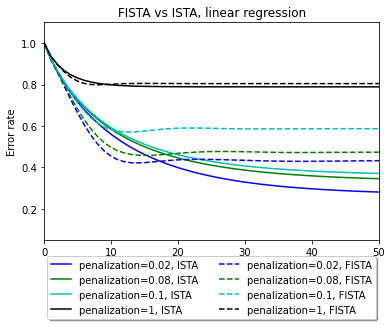

In [95]:
fig = plt.figure()
plt.plot(lin2[2], 'b', label = 'penalization=0.02, ISTA')
plt.plot(lin3[2], 'g', label = 'penalization=0.08, ISTA')
plt.plot(lin4[2], 'c', label = 'penalization=0.1, ISTA')
plt.plot(lin6[2], 'k', label = 'penalization=1, ISTA')
plt.plot(lin2f[2], 'b--', label = 'penalization=0.02, FISTA')
plt.plot(lin3f[2], 'g--', label = 'penalization=0.08, FISTA')
plt.plot(lin4f[2], 'c--', label = 'penalization=0.1, FISTA')
plt.plot(lin6f[2], 'k--', label = 'penalization=1, FISTA')

plt.xlabel('Nb iterations')
plt.ylabel('Error rate')

plt.xlim(0, 50)
plt.ylim(0.05, 1.1)
plt.title('FISTA vs ISTA, linear regression')
ax = plt.subplot(111)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),  shadow=True, ncol=2)
plt.show()

<ipython-input-96-21720d75f1b9>:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


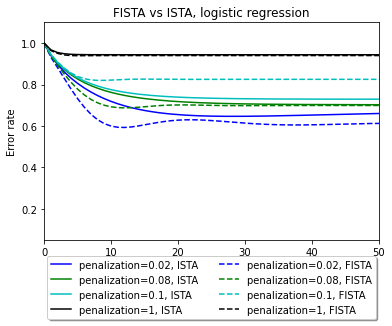

In [96]:
fig = plt.figure()
plt.plot(log2[2], 'b', label = 'penalization=0.02, ISTA')
plt.plot(log3[2], 'g', label = 'penalization=0.08, ISTA')
plt.plot(log4[2], 'c', label = 'penalization=0.1, ISTA')
plt.plot(log6[2], 'k', label = 'penalization=1, ISTA')
plt.plot(log2f[2], 'b--', label = 'penalization=0.02, FISTA')
plt.plot(log3f[2], 'g--', label = 'penalization=0.08, FISTA')
plt.plot(log4f[2], 'c--', label = 'penalization=0.1, FISTA')
plt.plot(log6f[2], 'k--', label = 'penalization=1, FISTA')

plt.xlabel('Nb iterations')
plt.ylabel('Error rate')

plt.xlim(0, 50)
plt.ylim(0.05, 1.1)
plt.title('FISTA vs ISTA, logistic regression')
ax = plt.subplot(111)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),  shadow=True, ncol=2)
plt.show()


### Comments
We see that when the penalty is lower, FISTA is also better than ISTA. 

Performance of the optimization algorithms for ridge and lasso penalizations

#FISTA

In [97]:
#linear regression
A, b = simu_linreg(coefs, n_samples=200, corr=0.5)
step= 1/lip_linreg(A)
lin_r= fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=0.01, n_iter =200)
lin_l= fista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step, s=0.01, n_iter =200)

#logistic regression
A, b = simu_logreg(coefs, n_samples=200, corr=0.5)
step= 1/lip_logreg(A)
log_r= fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=0.01, n_iter =200)
log_l= fista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step, s=0.01, n_iter =200)

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 2.57e-01 | 8.98e-01
      10 | 1.09e-01 | 3.22e-01
      20 | 1.11e-01 | 3.06e-01
      30 | 1.09e-01 | 2.96e-01
      40 | 1.09e-01 | 3.00e-01
      50 | 1.09e-01 | 2.98e-01
      60 | 1.09e-01 | 2.99e-01
      70 | 1.09e-01 | 2.99e-01
      80 | 1.09e-01 | 2.99e-01
      90 | 1.09e-01 | 2.99e-01
     100 | 1.09e-01 | 2.99e-01
     110 | 1.09e-01 | 2.99e-01
     120 | 1.09e-01 | 2.99e-01
     130 | 1.09e-01 | 2.99e-01
     140 | 1.09e-01 | 2.99e-01
     150 | 1.09e-01 | 2.99e-01
     160 | 1.09e-01 | 2.99e-01
     170 | 1.09e-01 | 2.99e-01
     180 | 1.09e-01 | 2.99e-01
     190 | 1.09e-01 | 2.99e-01
     200 | 1.09e-01 | 2.99e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 2.77e-01 | 9.01e-01
      10 | 1.85e-01 | 2.99e-01
      20 | 1.89e-01 | 2.75e-01
      30 | 1.86e-01 | 2.74e-01
      40 | 1.87e-01 | 2.76e-01
      50 | 1.86e-01 | 2.74e-01
      60 | 1.86e-01 | 2.75e-01
      70 | 1.86e-01 

<ipython-input-98-765a2f0b2ae4>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


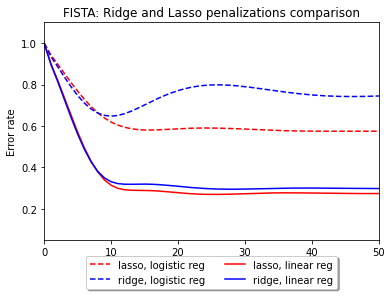

In [98]:
plt.plot(log_l[2], 'r--', label = 'lasso, logistic reg')
plt.plot(log_r[2], 'b--', label = 'ridge, logistic reg')
plt.plot(lin_l[2], 'r', label = 'lasso, linear reg')
plt.plot(lin_r[2], 'b', label = 'ridge, linear reg')

plt.xlabel('Nb iterations')
plt.ylabel('Error rate')

plt.xlim(0,50)
plt.ylim(0.05, 1.1)
plt.title('FISTA: Ridge and Lasso penalizations comparison')
ax = plt.subplot(111)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),  shadow=True, ncol=2)
#plt.legend()
plt.show()


#Here the value of penalization is what we increase.

In [99]:
# linear regression
A, b = simu_linreg(coefs, n_samples=200, corr=0.5)
step= 1/lip_linreg(A)
lin_r= fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=0.1, n_iter =200)
lin_l= fista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step, s=0.1, n_iter =200)

# logistic regression
A, b = simu_logreg(coefs, n_samples=200, corr=0.5)
step= 1/lip_logreg(A)
log_r= fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=0.1, n_iter =200)
log_l= fista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step, s=0.1, n_iter =200)

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 2.48e-01 | 8.96e-01
      10 | 2.55e-01 | 3.71e-01
      20 | 2.61e-01 | 3.44e-01
      30 | 2.56e-01 | 3.54e-01
      40 | 2.58e-01 | 3.49e-01
      50 | 2.58e-01 | 3.51e-01
      60 | 2.58e-01 | 3.51e-01
      70 | 2.58e-01 | 3.51e-01
      80 | 2.58e-01 | 3.51e-01
      90 | 2.58e-01 | 3.51e-01
     100 | 2.58e-01 | 3.51e-01
     110 | 2.58e-01 | 3.51e-01
     120 | 2.58e-01 | 3.51e-01
     130 | 2.58e-01 | 3.51e-01
     140 | 2.58e-01 | 3.51e-01
     150 | 2.58e-01 | 3.51e-01
     160 | 2.58e-01 | 3.51e-01
     170 | 2.58e-01 | 3.51e-01
     180 | 2.58e-01 | 3.51e-01
     190 | 2.58e-01 | 3.51e-01
     200 | 2.58e-01 | 3.51e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 3.90e-01 | 9.22e-01
      10 | 5.96e-01 | 5.34e-01
      20 | 5.94e-01 | 5.31e-01
      30 | 5.94e-01 | 5.32e-01
      40 | 5.94e-01 | 5.31e-01
      50 | 5.94e-01 | 5.31e-01
      60 | 5.94e-01 | 5.31e-01
      70 | 5.94e-01 

<ipython-input-100-39018e5928bc>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


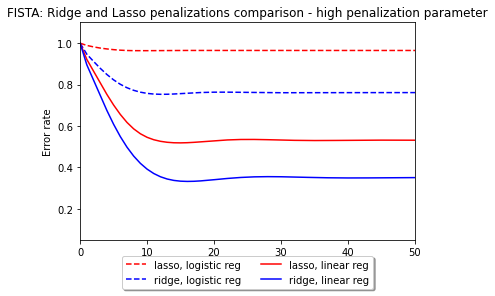

In [100]:
plt.plot(log_l[2], 'r--', label = 'lasso, logistic reg')
plt.plot(log_r[2], 'b--', label = 'ridge, logistic reg')
plt.plot(lin_l[2], 'r', label = 'lasso, linear reg')
plt.plot(lin_r[2], 'b', label = 'ridge, linear reg')

plt.xlabel('Nb iterations')
plt.ylabel('Error rate')

plt.xlim(0,50)
plt.ylim(0.05, 1.1)
plt.title('FISTA: Ridge and Lasso penalizations comparison - high penalization parameter')
ax = plt.subplot(111)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),  shadow=True, ncol=2)
#plt.legend()
plt.show()

#ISTA

In [101]:
# linear regression
A, b = simu_linreg(coefs, n_samples=200, corr=0.5)
step= 1/lip_linreg(A)
lin_r= ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=0.01, n_iter =200)
lin_l= ista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step, s=0.01, n_iter =200)

# logistic regression
A, b = simu_logreg(coefs, n_samples=200, corr=0.5)
step= 1/lip_logreg(A)
log_r= ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=0.01, n_iter =200)
log_l= ista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step, s=0.01, n_iter =200)

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 2.53e-01 | 9.02e-01
      10 | 1.21e-01 | 4.84e-01
      20 | 1.07e-01 | 3.80e-01
      30 | 1.06e-01 | 3.61e-01
      40 | 1.07e-01 | 3.62e-01
      50 | 1.08e-01 | 3.65e-01
      60 | 1.08e-01 | 3.68e-01
      70 | 1.08e-01 | 3.70e-01
      80 | 1.09e-01 | 3.71e-01
      90 | 1.09e-01 | 3.72e-01
     100 | 1.09e-01 | 3.72e-01
     110 | 1.09e-01 | 3.73e-01
     120 | 1.09e-01 | 3.73e-01
     130 | 1.09e-01 | 3.73e-01
     140 | 1.09e-01 | 3.73e-01
     150 | 1.09e-01 | 3.73e-01
     160 | 1.09e-01 | 3.73e-01
     170 | 1.09e-01 | 3.73e-01
     180 | 1.09e-01 | 3.73e-01
     190 | 1.09e-01 | 3.73e-01
     200 | 1.09e-01 | 3.73e-01
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 2.72e-01 | 9.05e-01
      10 | 1.82e-01 | 4.90e-01
      20 | 1.78e-01 | 3.78e-01
      30 | 1.80e-01 | 3.52e-01
      40 | 1.82e-01 | 3.48e-01
      50 | 1.84e-01 | 3.49e-01
      60 | 1.85e-01 | 3.50e-01
      70 | 1.85e-01 | 

<ipython-input-102-60dfd816f404>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


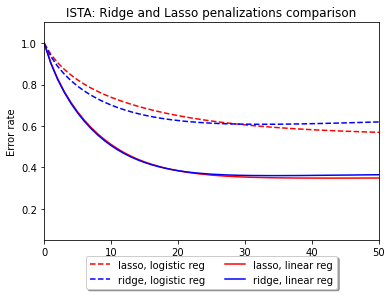

In [102]:
plt.plot(log_l[2], 'r--', label = 'lasso, logistic reg')
plt.plot(log_r[2], 'b--', label = 'ridge, logistic reg')
plt.plot(lin_l[2], 'r', label = 'lasso, linear reg')
plt.plot(lin_r[2], 'b', label = 'ridge, linear reg')

plt.xlabel('Nb iterations')
plt.ylabel('Error rate')

plt.xlim(0,50)
plt.ylim(0.05, 1.1)
plt.title('ISTA: Ridge and Lasso penalizations comparison')
ax = plt.subplot(111)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),  shadow=True, ncol=2)
#plt.legend()
plt.show()


# Comments
 
For both algorithms, the result depends on the strength of the penalty (the parameter "s"). So when s is large, the error rate is very large with the lasso penalty. 

And, this is due to the threshold effect of the lasso penalty: when s is large, almost all the coefficients are equal to zero.

When s is small, the penalty has no significant impact on the convergence.